# Budget vs Revenue by Genre (Scatter + Best Fit, Top 10 Genres)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.ticker as ticker
import seaborn as sns
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings("ignore")

In [3]:
imdb = pd.read_csv('imdb_movies.csv')
yt = pd.read_csv('movies_youtube_sentiments.csv')

In [3]:
imdb['revenue'] = imdb['revenue'].astype(int)
yt['gross'] = yt['gross'].astype(int)

imdb.rename(columns={'names': 'name'}, inplace = True)
merged_movies = pd.concat([imdb, yt], ignore_index=True)
pd.set_option('display.max_columns', None)
merged_movies.head(1)
unique_movies = merged_movies.drop_duplicates(subset = 'name')

# Replace non-breaking spaces with regular spaces
unique_movies['genre'] = unique_movies['genre'].str.replace('\xa0', ' ', regex=True)

# Now perform the split operation
unique_movies['genre'] = unique_movies['genre'].str.split(', ')

# Use explode to create individual rows for each genre
unique_movies_exploded = unique_movies.explode('genre')

unique_movies_exploded['revenue'] = unique_movies_exploded['revenue'].fillna(0)
unique_movies_exploded['revenue'] = unique_movies_exploded['revenue'].astype(int)
unique_movies_exploded['gross'] = unique_movies_exploded['gross'].fillna(0).astype(int)

unique_movies_exploded.reset_index(drop=True, inplace=True)
unique_movies_exploded.loc[unique_movies_exploded['revenue'] == 0, 'revenue'] = unique_movies_exploded.loc[unique_movies_exploded['revenue'] == 0, 'gross']
unique_movies_exploded = unique_movies_exploded.drop('gross', axis = 1)

genre_avg_box_office = unique_movies_exploded.groupby('genre')['revenue'].mean()

genre_avg_box_office_sorted = genre_avg_box_office.sort_values(ascending=False)
genre_avg_box_office_sorted = genre_avg_box_office_sorted.drop('TV Movie')

genre_avg_box_office_df = unique_movies_exploded[['revenue', 'genre']]
genre_avg_box_office_df_filter = genre_avg_box_office_df[genre_avg_box_office_df['genre'] != 'TV Movie']

genre_revenue = genre_avg_box_office_df_filter.groupby('genre')['revenue'].mean().sort_values(ascending = False)
top_10_genres = genre_revenue.head(10).index.tolist()

top_10_genres_moneywise = genre_avg_box_office_df_filter[genre_avg_box_office_df_filter['genre'].isin(top_10_genres)]
top_10_genres_moneywise['genre'] = pd.Categorical(top_10_genres_moneywise['genre'], categories=top_10_genres, ordered=True)

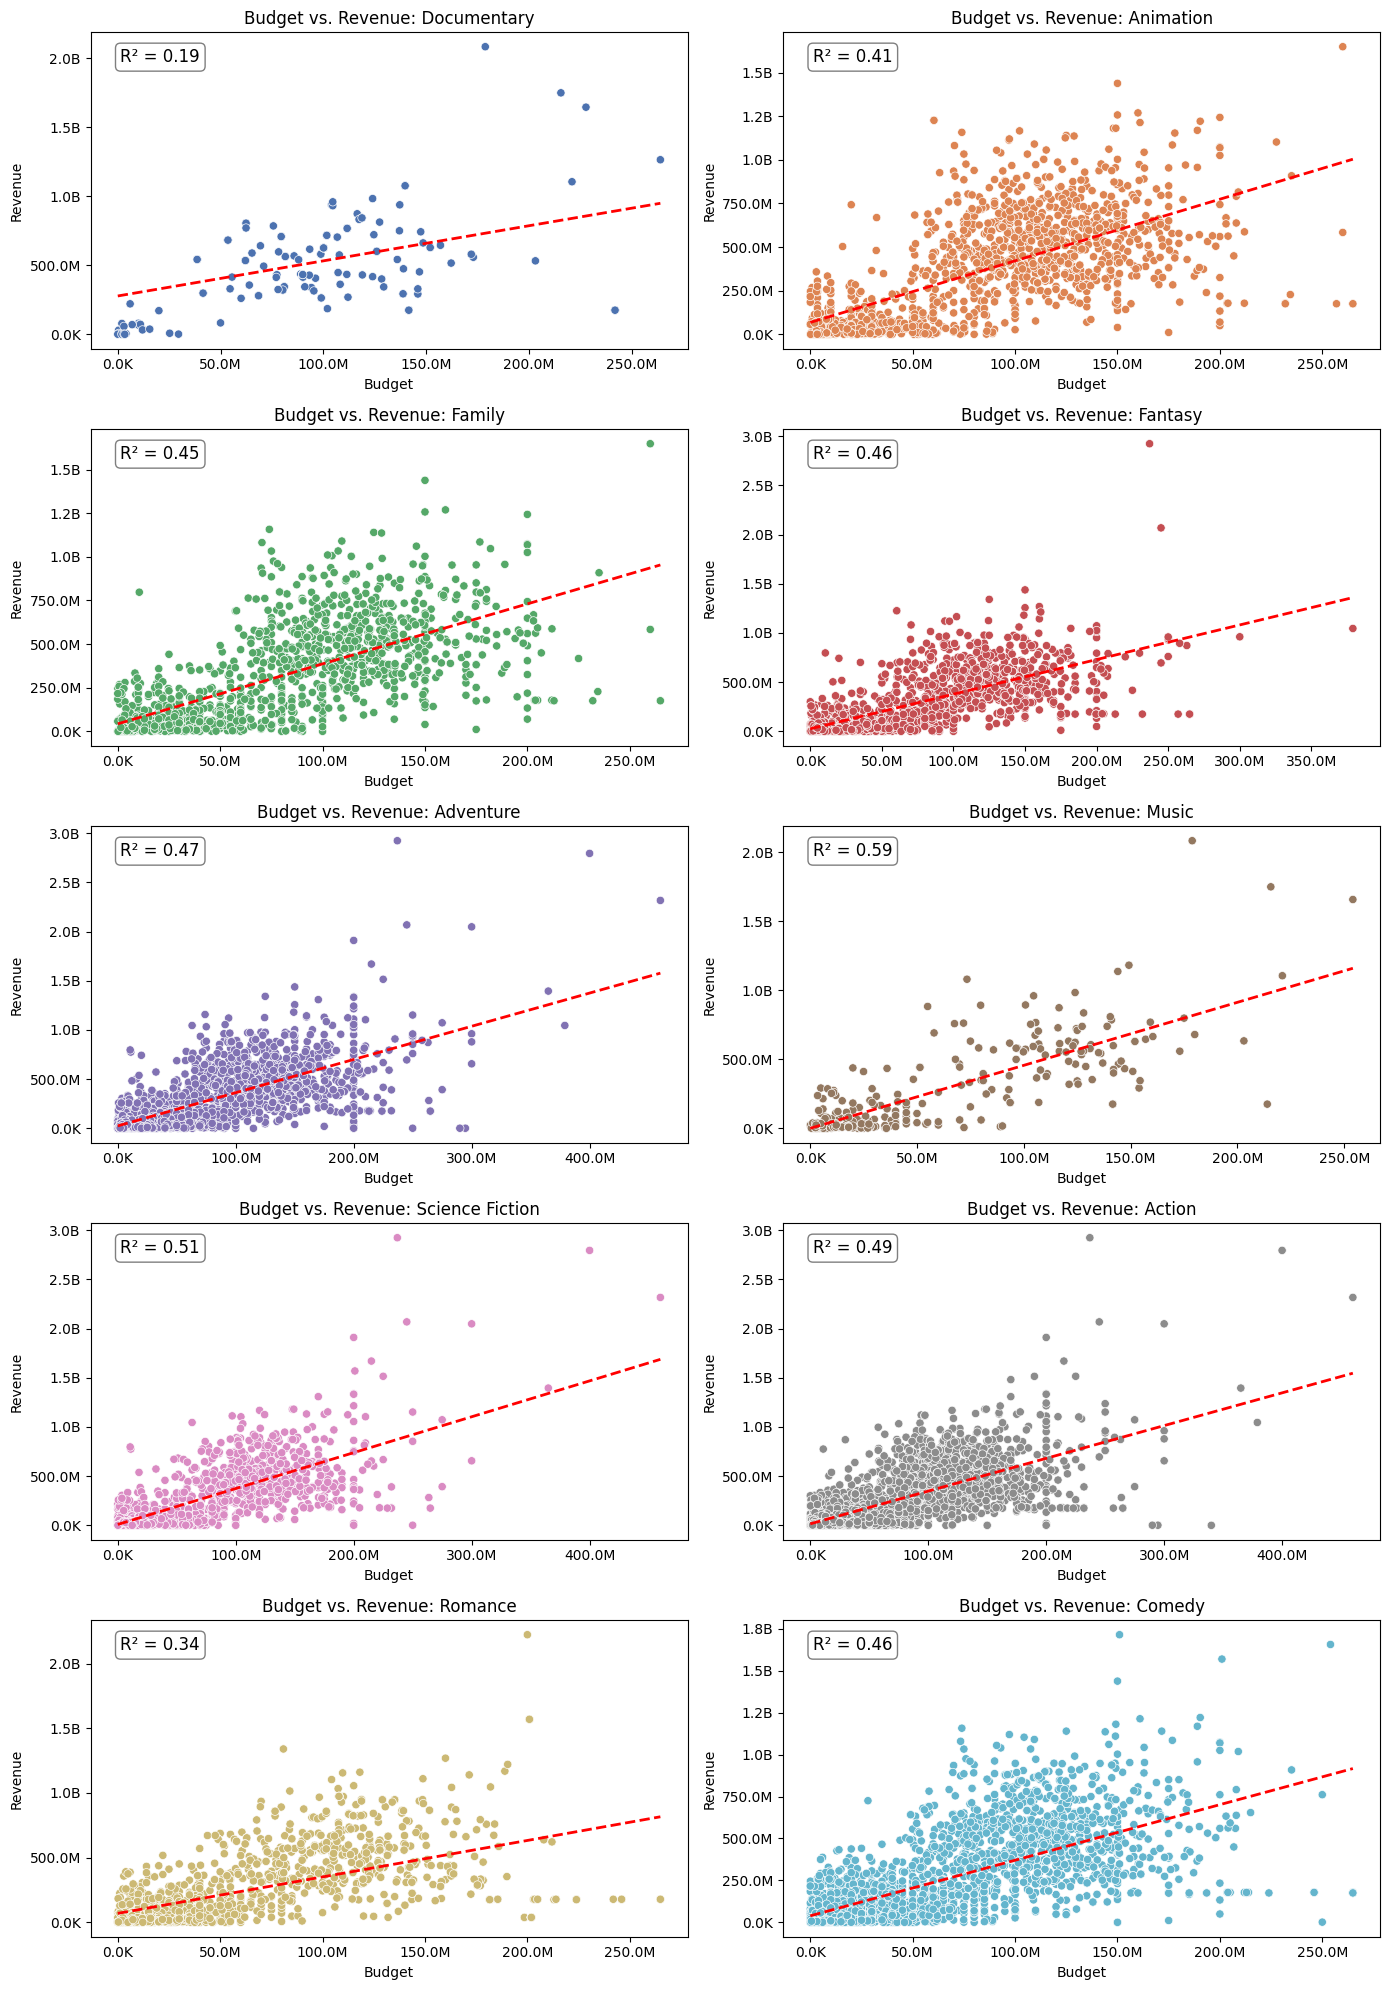

In [4]:
unique_movies_exploded['budget_x'] = unique_movies_exploded['budget_x'].fillna(0)
unique_movies_exploded['budget_x'] = unique_movies_exploded['budget_x'].astype(int)
unique_movies_exploded['budget'] = unique_movies_exploded['budget'].fillna(0).astype(int)

unique_movies_exploded.reset_index(drop=True, inplace=True)
unique_movies_exploded.loc[unique_movies_exploded['budget_x'] == 0, 'budget_x'] = unique_movies_exploded.loc[unique_movies_exploded['budget_x'] == 0, 'budget']
unique_movies_exploded = unique_movies_exploded.drop('budget', axis = 1)
unique_movies_dropped_bad_budgets = unique_movies_exploded[unique_movies_exploded['budget_x'] != 0]
unique_movies_dropped_bad_budgets_top10 = unique_movies_dropped_bad_budgets[unique_movies_dropped_bad_budgets['genre'].isin(top_10_genres)]
unique_movies_dropped_bad_budgets_top10['genre'] = pd.Categorical(unique_movies_dropped_bad_budgets_top10['genre'],
                                                            categories=top_10_genres, ordered=True)

UMDBBT10 = unique_movies_dropped_bad_budgets_top10

top_10_genres_listoflists = []

for i in top_10_genres:
    top_10_genres_listoflists.append([i])


def millions_billions_formatter(x, pos):
    """Convert numbers to 'Millions' or 'Billions'."""
    if x >= 1e9:  # For values 1 billion or larger
        return f'{x * 1e-9:.1f}B'
    elif x >= 1e6:  # For values 1 million or larger
        return f'{x * 1e-6:.1f}M'
    return f'{x * 1e-3:.1f}K'  # For values less than 1 mi

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(14, 20))  # Adjust as necessary
axes = axes.flatten()

for i, genres in enumerate(top_10_genres_listoflists):
    subframe = UMDBBT10[UMDBBT10['genre'].isin(genres)]
    sns.scatterplot(data = subframe, x = 'budget_x', y = 'revenue',
                    hue = 'genre', ax = axes[i], palette = 'deep', legend = False)
    axes[i].set_title('Budget vs. Revenue: ' + genres[0])
    axes[i].set_xlabel('Budget')
    axes[i].set_ylabel('Revenue')


    # Ensure data is in appropriate format
    x = subframe['budget_x'].values.reshape(-1, 1)  # Feature
    y = subframe['revenue'].values  # Target

    # Fit the model
    model = LinearRegression()
    model.fit(x, y)

    # Calculate the line of best fit
    x_fit = np.linspace(x.min(), x.max(), 100)  # 100 points for a smooth line
    y_fit = model.predict(x_fit.reshape(-1, 1))

    # Plot the line of best fit
    axes[i].plot(x_fit, y_fit, color='red', linestyle='--', linewidth=2, label='Best Fit')

    r_squared = model.score(x, y)  # Score the model
    axes[i].text(0.05, 0.95, f'R² = {r_squared:.2f}', transform=axes[i].transAxes, 
                 fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

    axes[i].xaxis.set_major_formatter(ticker.FuncFormatter(millions_billions_formatter))
    axes[i].yaxis.set_major_formatter(ticker.FuncFormatter(millions_billions_formatter))

plt.tight_layout()
plt.show()